# Autoencoder

We inspired our encoder in the one used in CFGEN, which has is a multi-layer perceptron (MLP) with two hidden layers of dimensions
[512, 256] that map the input to a 50-dimensional latent space.

In [2]:
# Autoencoder notebook but not for training just for using to encode and decode

import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from typing import List, Optional, Callable
import torch.nn as nn
import torch.nn.functional as F
from scvi.distributions import NegativeBinomial
import torch.nn.functional as F
import scanpy as sc


/zhome/6a/4/214382/venv_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# -------------------------------
# Define MLP (like the one in CFGEN)
# -------------------------------
class MLP(nn.Module):
    def __init__(self, 
                 dims: List[int],
                 batch_norm: bool, 
                 dropout: bool, 
                 dropout_p: float, 
                 activation: Optional[Callable] = nn.ELU, 
                 final_activation: Optional[str] = None):
        super().__init__()
        self.dims = dims
        self.batch_norm = batch_norm
        self.activation = activation
        layers = []
        for i in range(len(dims[:-2])):
            block = [nn.Linear(dims[i], dims[i+1])]
            if batch_norm:
                block.append(nn.BatchNorm1d(dims[i+1]))
            block.append(activation())
            if dropout:
                block.append(nn.Dropout(dropout_p))
            layers.append(nn.Sequential(*block))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)
        if final_activation == "tanh":
            self.final_activation = nn.Tanh()
        elif final_activation == "sigmoid":
            self.final_activation = nn.Sigmoid()
        else:
            self.final_activation = None

    def forward(self, x):
        x = self.net(x)
        return x if self.final_activation is None else self.final_activation(x)

In [4]:

# -------------------------------
# NB Autoencoder
# -------------------------------
class NB_Autoencoder(nn.Module):
    def __init__(self,
                 num_features: int,
                 latent_dim: int = 50,
                 hidden_dims: List[int] = [512, 256],
                 dropout_p: float = 0.1,
                 l2_reg: float = 1e-5,
                 kl_reg: float = 0):
        super().__init__()
        self.num_features = num_features
        self.latent_dim = latent_dim
        self.l2_reg = l2_reg
        self.kl_reg = kl_reg

        self.hidden_encoder = MLP(
        dims=[num_features, *hidden_dims, latent_dim],
        batch_norm=True,
        dropout=False,
        dropout_p=dropout_p
        )
        #self.latent_layer = nn.Linear(hidden_dims[-1], latent_dim)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.decoder = MLP(
            dims=[latent_dim, *hidden_dims[::-1], num_features],
            batch_norm=True,
            dropout=False,
            dropout_p=dropout_p
        )

        #self.log_theta = nn.Parameter(torch.randn(num_features) * 0.01)
        self.theta = torch.nn.Parameter(torch.randn(num_features), requires_grad=True)
    def forward(self, x):
        
        z = self.hidden_encoder(x["X_norm"])
        
        #z = self.latent_layer(h)
        # Raw decoded logits
        logits = self.decoder(z)   # shape (batch, num_genes)
        
        # Softmax over genes → normalized probabilities
        gene_probs = F.softmax(logits, dim=1)
        
        # Library size of each cell (sum of counts)
        library_size = x["X"].sum(1).unsqueeze(1).to(self.device)  # shape (batch, 1)
        
        # Scale probabilities by library size → mean parameter μ
        mu = gene_probs * library_size
 

        #theta = torch.exp(self.log_theta).unsqueeze(0).expand_as(mu)
        return {"z": z, "mu": mu, "theta": self.theta}

    def encode(self, x):
        z = self.hidden_encoder(x)
        return z
        
    def decode(self, z, library_size=None):
        """
        Decode latent vectors z to NB parameters mu, theta.
        z: (batch, latent_dim)
        library_size: (batch, 1) sum of counts per cell; if None, use 1.0
        """
        logits = self.decoder(z)  # (batch, num_genes)
        gene_probs = F.softmax(logits, dim=1)  # softmax over genes
    
        if library_size is None:
            # Use average library size 1.0 if not provided
            library_size = torch.ones(z.size(0), 1, device=z.device)
    
        mu = gene_probs * library_size  # scale by library size
        #theta = torch.exp(self.log_theta).unsqueeze(0).expand_as(mu)
        return {"mu": mu, "theta": self.theta}

    


   

    def loss_function(self, x, outputs):
        """
        Compute loss using scvi NegativeBinomial.
        """
        mu = outputs["mu"]          # (batch, n_genes)
        theta = outputs["theta"]    # (batch, n_genes)
        z = outputs["z"]            # latent
    
        # scvi NegativeBinomial expects mu and theta
        nb_dist = NegativeBinomial(mu=mu, theta=torch.exp(self.theta))
        nll = -nb_dist.log_prob(x).sum(dim=1).mean()  # mean over batch
        
        # Optional regularization
        #l2_loss = sum((p**2).sum() for p in self.parameters()) * self.l2_reg
        #l_loss = (z**2).mean() * self.kl_reg
    
        loss = nll #+ l2_loss + kl_loss
        return {"loss": loss, "nll": nll}


In [5]:
# dataloader for the 

import torch
from torch.utils.data import Dataset, DataLoader

class CountsDataset(Dataset):
    def __init__(self, X, y=None):
        """
        X: raw counts tensor (num_cells, num_genes)
        y: optional labels tensor (num_cells,)
        """
        if hasattr(X, "toarray"):
            X = X.toarray()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.X_norm = torch.log1p(self.X)  # log1p = log(1 + x)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        self.n_samples = self.X.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = dict(
            X=self.X[idx],
            X_norm=self.X_norm[idx]
        )
        if self.y is not None:
            sample["y"] = self.y[idx]
        return sample




In [8]:
#check if it's corrupted
import anndata as ad
import numpy as np
input_file_path = "/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train.h5ad"
#adata = ad.read_h5ad("/zhome/99/9/213566/deepL/adata_preprocessed_subset.h5ad", backed='r')
adata = ad.read_h5ad(input_file_path)
adata.obs.head()
X = adata.layers["X_counts"]
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
print(X)
log_transformed_x = torch.log1p(X)
print(log_transformed_x)


torch.Size([2110, 8573])
tensor([[0., 0., 5.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 4.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0.0000, 0.0000, 1.7918,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6931, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6931, 0.0000, 1.6094,  ..., 0.6931, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [9]:
# -------------------------------
# Main training + encoding
# -------------------------------
input_file = input_file_path
latent_dim = 50
hidden_dims = [512, 256]
batch_size = 512
epochs = 1000
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load data ---
adata = ad.read_h5ad(input_file)

# Load RAW COUNTS
X = adata.layers["X_counts"]
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)



dataset = CountsDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Initialize model ---
num_genes = adata.n_vars
model = NB_Autoencoder(num_features=num_genes,
                       latent_dim=latent_dim,
                       hidden_dims=hidden_dims)
model = model.to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# --- Training loop ---
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        # Use log-transformed input for encoder
        
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

        # Forward pass
        outputs = model(batch)

        # Compute loss on raw counts
        loss_dict = model.loss_function(batch["X"], outputs)
        loss = loss_dict["loss"]

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        #epoch_loss += loss.item() * x_raw.size(0)
        epoch_loss += loss.item() * batch["X"].size(0)

    epoch_loss /= len(dataset)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

# Save trained model
model_file = input_file_path.replace(".h5ad", "_nb_autoencoder.pt")
torch.save(model.state_dict(), model_file)
print(f"Trained model saved to {model_file}")



/tmp/ipykernel_2117112/2640616511.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Epoch 50/1000 - Loss: 2585.4582
Epoch 100/1000 - Loss: 2394.8396
Epoch 150/1000 - Loss: 2229.4602
Epoch 200/1000 - Loss: 2087.1486
Epoch 250/1000 - Loss: 1961.0244
Epoch 300/1000 - Loss: 1856.6687
Epoch 350/1000 - Loss: 1784.0154
Epoch 400/1000 - Loss: 1735.0968
Epoch 450/1000 - Loss: 1693.4878
Epoch 500/1000 - Loss: 1654.0659
Epoch 550/1000 - Loss: 1632.4590
Epoch 600/1000 - Loss: 1610.3624
Epoch 650/1000 - Loss: 1597.5446
Epoch 700/1000 - Loss: 1575.0835
Epoch 750/1000 - Loss: 1562.1110
Epoch 800/1000 - Loss: 1544.6760
Epoch 850/1000 - Loss: 1536.8192
Epoch 900/1000 - Loss: 1527.5390
Epoch 950/1000 - Loss: 1517.0774
Epoch 1000/1000 - Loss: 1515.2075
Trained model saved to /dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt


In [6]:
# Model parameters must match training
num_genes = 8573  # for example, pbmc3k
latent_dim = 50
hidden_dims = [512, 256]

model_file = "/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NB_Autoencoder(
    num_features=num_genes,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims
)
model.load_state_dict(torch.load(model_file, map_location=device))
model = model.to(device)
model.eval()  

NB_Autoencoder(
  (hidden_encoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8573, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
# Load counts for testing
adata_test = ad.read_h5ad("/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train.h5ad")
X_test = adata_test.layers["X_counts"]

if hasattr(X_test, "toarray"):
    X_test = X_test.toarray()
X_test = torch.tensor(X_test, dtype=torch.float32)

# Create Dataset / DataLoader
test_dataset = CountsDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


/tmp/ipykernel_3485163/2640616511.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


In [12]:
X_merged = []
labels = []
from tqdm import tqdm
model.eval()
device = next(model.parameters()).device
latent_noise_scale = 0.05
with torch.no_grad():
    for batch in tqdm(test_loader):
        x_raw = batch["X"].to(device)
        x_norm = batch["X_norm"].to(device)

        # Encode + decode
        z = model.encode(x_norm)
        
        library_size = x_raw.sum(1).unsqueeze(1)
        outputs = model.decode(z, library_size)
        mu_hat = outputs["mu"]
        theta = torch.exp(outputs["theta"])

        # Convert mu, theta → PyTorch NB parameters
        
        nb_dist = NegativeBinomial(mu=mu_hat, theta=theta)
        X_hat = nb_dist.sample()

        # --- Ensure 2D arrays before appending ---
        x_real = x_raw.cpu().numpy()
        if x_real.ndim == 1:
            x_real = x_real[np.newaxis, :]  # shape (1, n_genes)

        x_fake = X_hat.cpu().numpy()
        if x_fake.ndim == 1:
            x_fake = x_fake[np.newaxis, :]  # shape (1, n_genes)

        X_merged.append(x_real)
        X_merged.append(x_fake)
        labels.extend(["Real"] * x_real.shape[0])
        labels.extend(["Generated"] * x_fake.shape[0])

# Combine batches
X_merged = np.concatenate(X_merged, axis=0)
labels = np.array(labels)

print("X_merged shape:", X_merged.shape)
print("labels shape:", labels.shape)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.63it/s]


X_merged shape: (4220, 8573)
labels shape: (4220,)


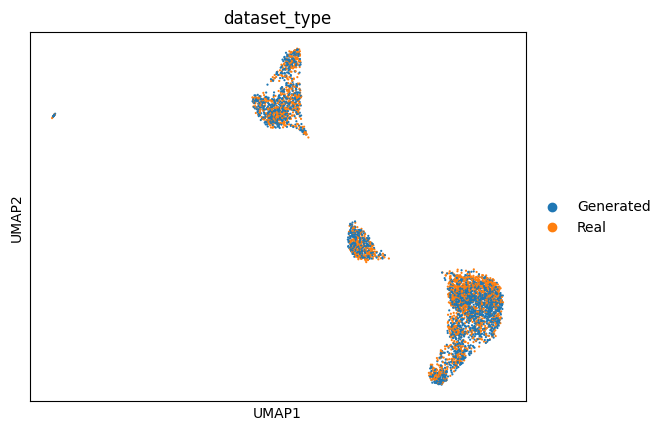

<Axes: title={'center': 'dataset_type'}, xlabel='UMAP1', ylabel='UMAP2'>

In [13]:

# --- Build AnnData object ---
adata = sc.AnnData(X=X_merged, obs={"dataset_type": labels})

# --- Preprocessing ---
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# --- Dimensionality reduction ---
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# --- Visualization ---
import matplotlib.pyplot as plt
sc.pl.umap(adata, color="dataset_type", s=10, show=True)
plt.show()  # ensures the figure is displayed
sc.pl.umap(adata, color="dataset_type", s=10, show=False, save="_real_vs_generated.png")


In [15]:
print("theta range:", torch.exp(model.theta).min(), torch.exp(model.theta).max())


theta range: tensor(1.1168, device='cuda:0', grad_fn=<MinBackward1>) tensor(502.3755, device='cuda:0', grad_fn=<MaxBackward1>)
